This file includes many things from random forest fine tuning to Unet and resnet implementations. This file is used to deeply investigate how different models react to our dataset, espacially when data augmentation is done manually. Also hyperparameter and their possible effects are well discovered at this stage. Nothing in this file later used in reports or presentations.

In [2]:
import os
import ast
import h5py
import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

Reading and organizing the combined (sentinal + csv) data

Features (X):

Spectral Bands: Sentinel-2 bands (B2 to B12 and their variations) capture various spectral properties of vegetation:

B2 (Blue): Sensitive to chlorophyll absorption.
B3 (Green): Highlights vegetation vigor.
B4 (Red): Sensitive to chlorophyll content.
B5-B7, B8 (NIR): Represent plant biomass and structure.
B8A (Narrow NIR): Useful for vegetation monitoring.
B11-B12 (SWIR): Indicates moisture content and stress.
Variations (e.g., B2_1, B2_2, etc.) can represent temporal changes or transformations, which might improve accuracy if temporal analysis is relevant.

Vegetation Indices: These indices summarize spectral properties into meaningful vegetation traits:

NDVI: Indicates vegetation health and greenness.
EVI: Similar to NDVI but reduces canopy background effects.
SAVI: Adjusted for soil brightness.
NDWI: Sensitive to vegetation water content.

In [ ]:
input_file = "data/combined_data4.geojson"
## Read combined data
combined_gdf = gpd.read_file(input_file)

In [3]:
print(combined_gdf.head())
print(combined_gdf.crs)
print(combined_gdf.columns.to_list())
combined_gdf.crs = "EPSG:25832"
print(combined_gdf.crs)
print(combined_gdf.shape)

                     id                                                B11  \
0  0000000000000000050b  [ [ 0.23570001125335693, 0.23570001125335693, ...   
1  0000000000000000050c  [ [ 0.31589999794960022, 0.31589999794960022, ...   
2  0000000000000000050d  [ [ 0.19909998774528503, 0.18310000002384186, ...   
3  0000000000000000050e  [ [ 0.22779999673366547, 0.22419999539852142, ...   
4  0000000000000000050f  [ [ 0.25600001215934753, 0.26150000095367432, ...   

                                               B11_1  \
0                                               None   
1  [ [ 0.33454999327659607, 0.33454999327659607, ...   
2  [ [ 0.25055000185966492, 0.2463500052690506, 0...   
3  [ [ 0.26010000705718994, 0.25749999284744263, ...   
4  [ [ 0.28685000538825989, 0.29079997539520264, ...   

                                               B11_2  \
0  [ [ 0.25260001420974731, 0.25260001420974731, ...   
1  [ [ 0.36035001277923584, 0.36035001277923584, ...   
2  [ [ 0.33680000901222229

In [19]:
def flattenDf(df,col):
  #  flatten 5*5 matrix col in df and return a new df which include col_1~col_25
  flattened_df = pd.DataFrame(
      df[col].apply(lambda x: x.flatten()).tolist(),
      columns=[f'{col}_{i+1}' for i in range(25)]
  )
  df_new = pd.concat([df, flattened_df], axis=1)
  df_new = df_new.drop(columns=[col])
  return df_new

In [4]:
# for now, we just select the NDVI, and keep id&species
select_col = ['l1_leaf_types', 'l2_genus','l3_species', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']

select_df = combined_gdf[select_col]

In [5]:
print(select_df.isnull().sum())

l1_leaf_types       0
l2_genus            0
l3_species          0
EVI                 0
EVI2                0
EVI2_1           5483
EVI2_2            133
EVI2_3              3
EVI2_4           3535
EVI2_5              0
EVI2_6           2861
EVI2_7           3779
EVI_1            5483
EVI_2             133
EVI_3               3
EVI_4            3535
EVI_5               0
EVI_6            2861
EVI_7            3779
NDVI                0
NDVI_1           5483
NDVI_2            133
NDVI_3              3
NDVI_4           3535
NDVI_5              0
NDVI_6           2861
NDVI_7           3779
NDWI                0
NDWI_1           5483
NDWI_2            133
NDWI_3              3
NDWI_4           3535
NDWI_5              0
NDWI_6           2861
NDWI_7           3779
SAVI                0
SAVI_1           5483
SAVI_2            133
SAVI_3              3
SAVI_4           3535
SAVI_5              0
SAVI_6           2861
SAVI_7           3779
dtype: int64


In [22]:
# for now we just dorp the None
combined_gdf_cleaned = select_df.dropna().reset_index(drop=True)
print(combined_gdf_cleaned.shape)
print(combined_gdf_cleaned.isnull().any())

(26268, 43)
l1_leaf_types    False
l2_genus         False
l3_species       False
EVI              False
EVI2             False
EVI2_1           False
EVI2_2           False
EVI2_3           False
EVI2_4           False
EVI2_5           False
EVI2_6           False
EVI2_7           False
EVI_1            False
EVI_2            False
EVI_3            False
EVI_4            False
EVI_5            False
EVI_6            False
EVI_7            False
NDVI             False
NDVI_1           False
NDVI_2           False
NDVI_3           False
NDVI_4           False
NDVI_5           False
NDVI_6           False
NDVI_7           False
NDWI             False
NDWI_1           False
NDWI_2           False
NDWI_3           False
NDWI_4           False
NDWI_5           False
NDWI_6           False
NDWI_7           False
SAVI             False
SAVI_1           False
SAVI_2           False
SAVI_3           False
SAVI_4           False
SAVI_5           False
SAVI_6           False
SAVI_7           False

In [23]:
# load the labels
labels = np.array(combined_gdf_cleaned[['l1_leaf_types', 'l2_genus','l3_species']])
sen2 = np.array(combined_gdf_cleaned[['EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']])
# show the shape
print("Labels shape: " + str(labels.shape))
#print("Sen2 shape: " + str(sen2.shape))

# print the labels
print(labels[:])
print(sen2[:])
print(sen2.shape)

Labels shape: (26268, 3)
[['broadleaf' 'beech' 'european beech']
 ['broadleaf' 'beech' 'european beech']
 ['broadleaf' 'beech' 'european beech']
 ...
 ['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']]
[['[ [ 0.20749008911810152, 0.20749008911810152, 0.19399448468637809, 0.19399448468637809, 0.17264941854954027 ], [ 0.18811365650919964, 0.18811365650919964, 0.1849789855605749, 0.1849789855605749, 0.16339870893377503 ], [ 0.15306353645981172, 0.17718141664517226, 0.21298995013305966, 0.21298995013305966, 0.1739566666446915 ], [ 0.19121085741222177, 0.2207476943381205, 0.22820864778601127, 0.22820864778601127, 0.18666553060357882 ], [ 0.28203077196510823, 0.27142411560406604, 0.2212287710345307, 0.2212287710345307, 0.18814043369977704 ] ]'
  '[ [ 0.14782237840573534, 0.14782237840573534, 0.14476302135383265, 0.14476302135383265, 0.12484099071992923 ], [ 0.13129488527943947, 0.13129488527943947, 0.13603209468360802, 0.13603209468360

Working on Labels = > 1. Leaf type, 2. Genus class, 3. Specie of tree

In [24]:
labels_raw = np.array(combined_gdf_cleaned['l1_leaf_types'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l1 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l1[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l1_leaf_types'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l1_leaf_types'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l1_leaf_types'].value_counts())

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Unique species in first 19 samples:
['broadleaf']

All unique species:
['broadleaf' 'needleleaf']

Species distribution:
l1_leaf_types
broadleaf     14110
needleleaf    12158
Name: count, dtype: int64


(array([14110.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        12158.]),
 array([0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
        0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
        0.58823529, 0.64705882, 0.70588235, 0.76470588, 0.82352941,
        0.88235294, 0.94117647, 1.        ]),
 <BarContainer object of 17 artists>)

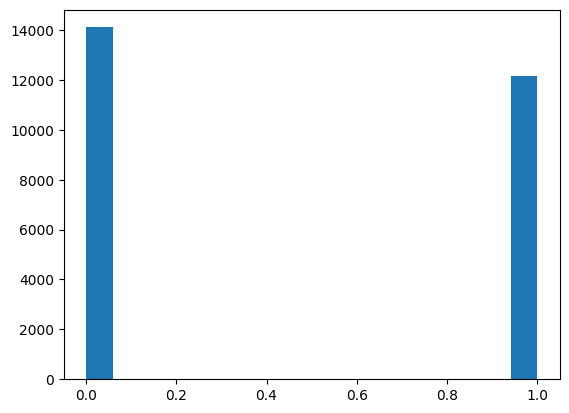

In [25]:
# Check the data distribution
plt.hist(np.argmax(labels_l1, axis=1), bins=17)

In [26]:
labels_raw = np.array(combined_gdf_cleaned['l2_genus'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l2 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l2[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l2_genus'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l2_genus'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l2_genus'].value_counts())

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique species in first 19 samples:
['beech']

All unique species:
['beech' 'long-lived deciduous' 'oak' 'short-lived deciduous'
 'douglas fir' 'fir' 'larch' 'pine' 'spruce']

Species distribution:
l2_genus
pine                     5012
oak                      4531
short-lived deciduous    3485
spruce                   3107
long-lived deciduous     3105
beech                    2989
larch                    1884
douglas fir              1657
fir                       498
Name: count, dtype: int64


(array([2989.,    0., 1657.,    0.,  498.,    0., 1884.,    0., 3105.,
           0., 4531.,    0., 5012.,    0., 3485.,    0., 3107.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

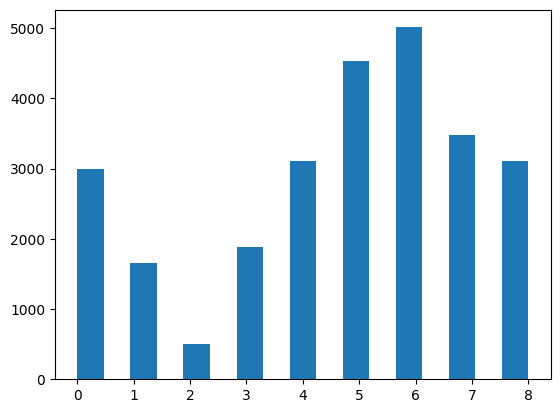

In [27]:
# Check the data distribution
plt.hist(np.argmax(labels_l2, axis=1), bins=17)

In [28]:
labels_raw = np.array(combined_gdf_cleaned['l3_species'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l3 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l3[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l3_species'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l3_species'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l3_species'].value_counts())

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique species in first 19 samples:
['european beech']

All unique species:
['european beech' 'linden' 'cherry' 'sycamore maple' 'european ash'
 'english oak' 'sessile oak' 'red oak' 'alder' 'poplar' 'birch'
 'douglas fir' 'silver fir' 'japanese larch' 'european larch' 'black pine'
 'weymouth pine' 'norway spruce' 'scots pine']

Species distribution:
l3_species
scots pine        4260
norway spruc

(array([3189.,  311.,  152., 1657., 2070., 1483., 2989.,  782., 1102.,
         125., 3107.,  296., 1116., 4260., 1345.,  498., 1786.]),
 array([ 0.        ,  1.05882353,  2.11764706,  3.17647059,  4.23529412,
         5.29411765,  6.35294118,  7.41176471,  8.47058824,  9.52941176,
        10.58823529, 11.64705882, 12.70588235, 13.76470588, 14.82352941,
        15.88235294, 16.94117647, 18.        ]),
 <BarContainer object of 17 artists>)

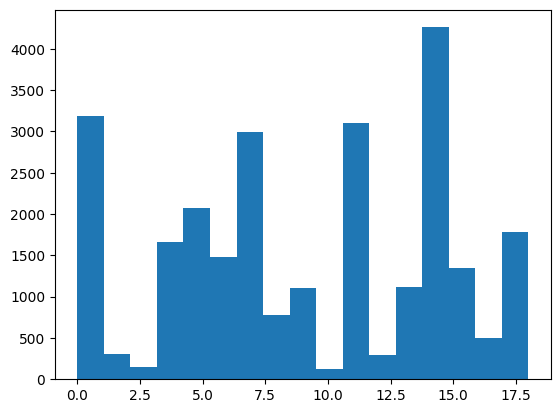

In [29]:
# Check the data distribution
plt.hist(np.argmax(labels_l3, axis=1), bins=17)

Working on Sentinal 2 Data

In [ ]:
# Print Sentinel-2 data
print("Sentinel-2 shape: " + str(sen2.shape))
sen2_depot = sen2 # so that I dont need to rerun the whole thing

Sentinel-2 shape: (26268, 40)


In [ ]:
# Convert string representation of arrays to actual numpy arrays
def convert_string_to_array(s):
	# Using ast.literal_eval to safely evaluate the string as a Python literal
	array_data = ast.literal_eval(s)
	return np.array(array_data)

# Convert all elements in sen2 to numpy arrays
sen2_arrays = np.array([convert_string_to_array(x) for x in sen2.flatten()])
number_samples = sen2.shape[0]
sen2_reshaped = sen2_arrays.reshape(number_samples, -1)

print("Post-processed Sentinel-2 data shape: ", sen2_reshaped.shape)

Post-processed Sentinel-2 data shape:  (26268, 1000)


In [79]:
print("Post-processed Sentinel-2 data:", type(sen2_reshaped[0][0]))
print(sen2_reshaped[0].shape)

Post-processed Sentinel-2 data: <class 'numpy.float64'>
(1000,)


In [70]:
#number_samples = sen2_reshaped.shape[0]
#X_sen2_res = np.reshape(sen2_reshaped, (number_samples, 5 * 5 * 40))

#print("Post-processed Sentinel-2 data shape: ", X_sen2_res.shape)

Post-processed Sentinel-2 data shape:  (26268, 1000)


In [80]:
combined_gdf_cleaned.columns.to_list()

['l1_leaf_types',
 'l2_genus',
 'l3_species',
 'EVI',
 'EVI2',
 'EVI2_1',
 'EVI2_2',
 'EVI2_3',
 'EVI2_4',
 'EVI2_5',
 'EVI2_6',
 'EVI2_7',
 'EVI_1',
 'EVI_2',
 'EVI_3',
 'EVI_4',
 'EVI_5',
 'EVI_6',
 'EVI_7',
 'NDVI',
 'NDVI_1',
 'NDVI_2',
 'NDVI_3',
 'NDVI_4',
 'NDVI_5',
 'NDVI_6',
 'NDVI_7',
 'NDWI',
 'NDWI_1',
 'NDWI_2',
 'NDWI_3',
 'NDWI_4',
 'NDWI_5',
 'NDWI_6',
 'NDWI_7',
 'SAVI',
 'SAVI_1',
 'SAVI_2',
 'SAVI_3',
 'SAVI_4',
 'SAVI_5',
 'SAVI_6',
 'SAVI_7']

In [ ]:
# The random forest expects a vector of features. Therefore,
# we concatenate all bands and pixels
#number_samples = sen2.shape[0]
#X = sen2
#print("Pre-processed Sentinel-2 data shape: ", X.shape)
#X = np.array([ast.literal_eval(x) for x in X.flatten()])
#X = X.reshape(number_samples, -1)
#print("Post-processed Sentinel-2 data shape: ", X.shape)
# Let us split the data into train and test
X = sen2_reshaped
TRAIN_SPLIT = int(number_samples * .8)

X_train = X[:TRAIN_SPLIT,:]
X_test = X[TRAIN_SPLIT:,:]

In [83]:
X_train.shape, X_test.shape, X.shape

((21014, 1000), (5254, 1000), (26268, 1000))

In [84]:
# The labels are one hot encoded, but the random forest requires
# the class number
y_train_l1 = np.argmax(labels_l1[0:TRAIN_SPLIT,:], axis=1)
y_test_l1 = np.argmax(labels_l1[TRAIN_SPLIT:26268,:], axis=1)

print("Post-processed train labels shape: ", y_train_l1.shape)

Post-processed train labels shape:  (21014,)


L1 leaf type Prediction is done with random forest below.

Accuracies:  [0.9183203401842664, 0.9163713678242381, 0.9213323883770376, 0.9165485471296952, 0.9220411055988661]
Mean Accuracy:  0.9189227498228206
F1 Scores:  [0.9183131369100526, 0.9163671671134674, 0.9213311930853061, 0.9165477900150018, 0.9220371896820458]
Mean F1 Score:  0.9189192953611748


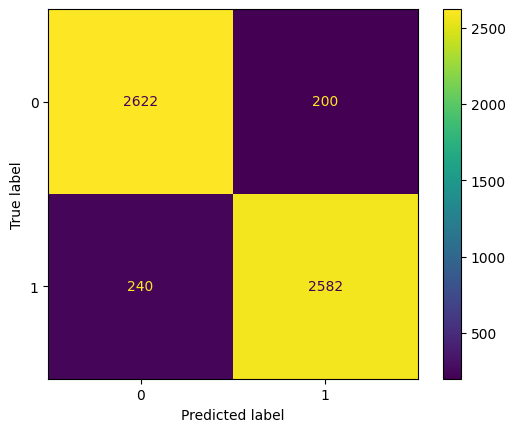

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import numpy as np

import matplotlib.pyplot as plt

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_l1)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Display the results
print("Accuracies: ", accuracies)
print("Mean Accuracy: ", np.mean(accuracies))
print("F1 Scores: ", f1_scores)
print("Mean F1 Score: ", np.mean(f1_scores))

# Display the confusion matrix for the last fold
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

The prediction above is made on L1:Leaf Types. Below is L2:Genus related.

The L2 data is inbalanced up to 10:1 ratio, which can cause the model to be biased (favoring high sample species). Before prediction takes place the genus dataset must be organized. 

In [86]:
labels_l2.shape

(26268, 9)

(array([2989.,    0., 1657.,    0.,  498.,    0., 1884.,    0., 3105.,
           0., 4531.,    0., 5012.,    0., 3485.,    0., 3107.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

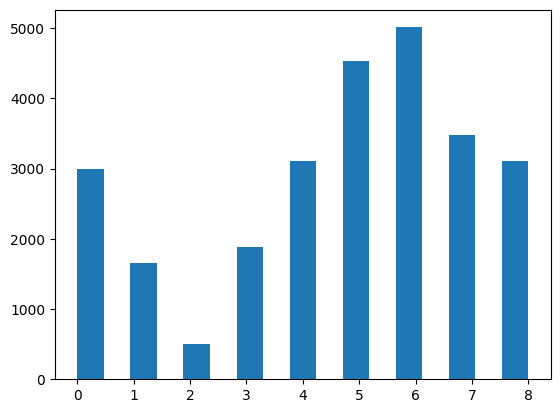

In [ ]:
# Check the data distribution
plt.hist(np.argmax(labels_l2, axis=1), bins=17)

Firstly, directly training with the imbalanced data to see the results.

In [88]:
# The labels are one hot encoded, but the random forest requires
# the class number
y_train = np.argmax(labels_l2[0:TRAIN_SPLIT,:], axis=1)
y_test = np.argmax(labels_l2[TRAIN_SPLIT:26268,:], axis=1)

print("Post-processed train labels shape: ", y_train.shape)

Post-processed train labels shape:  (21014,)


FROM HERE DIRECTLY JUMP TO THE SECTION AT THE BOTTOM WHERE SAMPLE SIZES OF L2 BECOME 5000

the code below attemps fusion for l1 and l2 but for now skipping it.

In [35]:
X_train_genus, X_test_genus, y_genus_train, y_genus_test = train_test_split(X, labels_l2, test_size=0.2, random_state=42)

# Add leaf type predictions as a feature
X_train_genus = np.hstack((X_train_genus, leaf_rf_classifier.predict(X_train_genus).reshape(-1, 1)))
X_test_genus = np.hstack((X_test_genus, y_leaf_pred_rf.reshape(-1, 1)))

genus_model = RandomForestClassifier()
genus_model.fit(X_train_genus, y_genus_train)

# Predict genus type
y_genus_pred = genus_model.predict(X_test_genus)
print("Genus Type Accuracy:", accuracy_score(y_genus_test, y_genus_pred))

Genus Type Accuracy: 0.3639132089836315


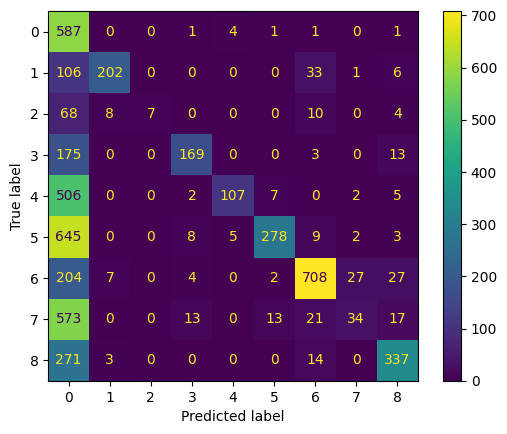

In [36]:
# Convert multilabel-indicator to single label format
y_genus_test_single = np.argmax(y_genus_test, axis=1)
y_genus_pred_single = np.argmax(y_genus_pred, axis=1)

ConfusionMatrixDisplay.from_predictions(y_genus_test_single, y_genus_pred_single)
plt.show()

In [38]:
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')

rf_classifier.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [22576, 21014]

In [31]:
y_pred_rf_l2 = rf_classifier.predict(X_test)

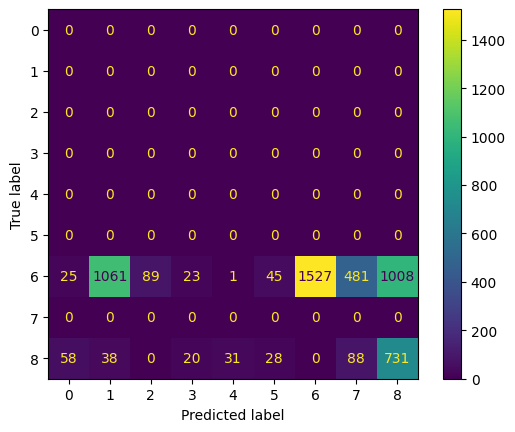

Accuracy Random Forest Classifier:  0.42976779596497905


In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_l2)
plt.show()

acc_rf_l2 = accuracy_score(y_test, y_pred_rf_l2)
print("Accuracy Random Forest Classifier: ", acc_rf_l2)

In [33]:
from sklearn.metrics import f1_score

# Calculate F1 score for y_pred_rf_l2
f1_rf_l2 = f1_score(y_test, y_pred_rf_l2, average='weighted')
print("F1 Score for Random Forest Classifier (L2): ", f1_rf_l2)
# Calculate F1 score for each class of label_l2
f1_rf_l2_per_class = f1_score(y_test, y_pred_rf_l2, average=None)
print("F1 Score for each class of Random Forest Classifier (L2): ", f1_rf_l2_per_class)

F1 Score for Random Forest Classifier (L2):  0.5290983871731022
F1 Score for each class of Random Forest Classifier (L2):  [0.         0.         0.         0.         0.         0.
 0.52773458 0.         0.53494329]


The conf. matrix above suggest the trained model tends to predict the labels of 6,7,8 which are corresponding to the high samples genus classes. Due to this fact, a data balancing is experimented below.

Using SMOTE in order to increase the sample size of only 3rd class in genus. After that applying  skf will be more meaningfull

Accuracies:  [0.6821469356680624, 0.675485344499429, 0.6684430909783022, 0.683038263849229, 0.6683799733485627]
Mean Accuracy:  0.6754987216687172
F1 Scores:  [0.6766248902455048, 0.6695181122141277, 0.6629372676784009, 0.6768386402835047, 0.661238492310693]
Mean F1 Score:  0.6694314805464463


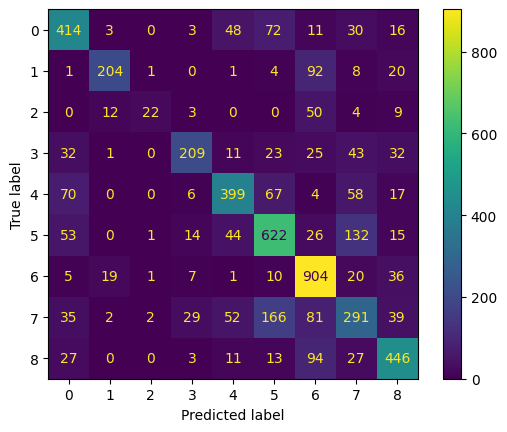

In [61]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X, np.argmax(labels_l2, axis=1)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = np.argmax(labels_l2[train_index], axis=1), np.argmax(labels_l2[test_index], axis=1)
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Display the results
print("Accuracies: ", accuracies)
print("Mean Accuracy: ", np.mean(accuracies))
print("F1 Scores: ", f1_scores)
print("Mean F1 Score: ", np.mean(f1_scores))

# Display the confusion matrix for the last fold
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


Fold 1
Fold 1 Accuracy: 0.6821
Fold 1 Macro F1: 0.6524
Fold 1 Weighted F1: 0.6766
Per-class F1 scores: {0: '0.6672', 1: '0.7446', 2: '0.4308', 3: '0.7086', 4: '0.6459', 5: '0.6813', 6: '0.8048', 7: '0.4697', 8: '0.7182'}

Fold 2
Fold 2 Accuracy: 0.6755
Fold 2 Macro F1: 0.6473
Fold 2 Weighted F1: 0.6695
Per-class F1 scores: {0: '0.6525', 1: '0.6678', 2: '0.4853', 3: '0.7185', 4: '0.6272', 5: '0.6867', 6: '0.7949', 7: '0.4872', 8: '0.7061'}

Fold 3
Fold 3 Accuracy: 0.6684
Fold 3 Macro F1: 0.6347
Fold 3 Weighted F1: 0.6629
Per-class F1 scores: {0: '0.6752', 1: '0.7273', 2: '0.3750', 3: '0.6857', 4: '0.6242', 5: '0.6538', 6: '0.7925', 7: '0.4702', 8: '0.7087'}

Fold 4
Fold 4 Accuracy: 0.6830
Fold 4 Macro F1: 0.6483
Fold 4 Weighted F1: 0.6768
Per-class F1 scores: {0: '0.6797', 1: '0.7405', 2: '0.3810', 3: '0.7097', 4: '0.6478', 5: '0.6725', 6: '0.8072', 7: '0.4583', 8: '0.7380'}

Fold 5
Fold 5 Accuracy: 0.6684
Fold 5 Macro F1: 0.6281
Fold 5 Weighted F1: 0.6612
Per-class F1 scores: {0: '0.6

<Figure size 1000x800 with 0 Axes>

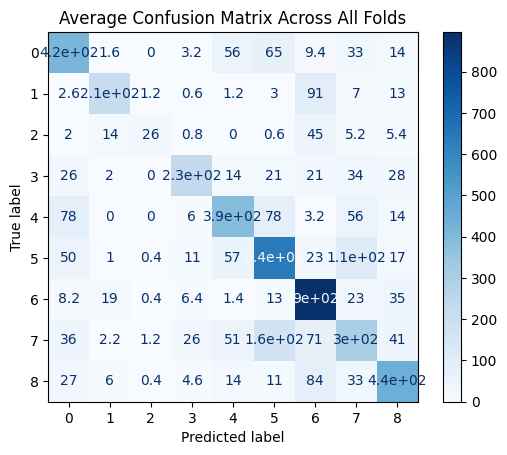

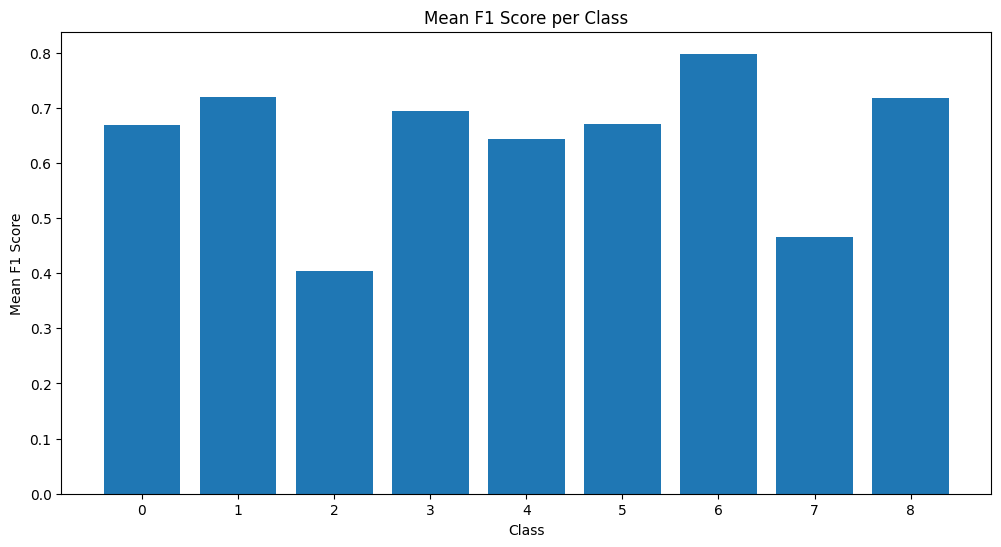

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []
per_class_f1 = []  # Add per-class metrics

# Perform Stratified K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(skf.split(X, np.argmax(labels_l2, axis=1)), 1):
    print(f"\nFold {fold}")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = np.argmax(labels_l2[train_index], axis=1), np.argmax(labels_l2[test_index], axis=1)
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced',
        n_jobs=-1  # Use all available cores
    )
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1_weighted)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    per_class_f1.append(f1_per_class)
    
    # Print fold results
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Macro F1: {f1_macro:.4f}")
    print(f"Fold {fold} Weighted F1: {f1_weighted:.4f}")
    print("Per-class F1 scores:", {i: f"{score:.4f}" for i, score in enumerate(f1_per_class)})

# Calculate and display final results
print("\nFinal Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
print(f"Mean Weighted F1: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")

# Calculate mean per-class F1 scores
mean_per_class_f1 = np.mean(per_class_f1, axis=0)
print("\nMean F1 score per class:")
for class_idx, f1 in enumerate(mean_per_class_f1):
    print(f"Class {class_idx}: {f1:.4f}")

# Plot confusion matrix (average across all folds)
plt.figure(figsize=(10, 8))
mean_cm = np.mean(confusion_matrices, axis=0)
ConfusionMatrixDisplay(
    confusion_matrix=mean_cm,
    display_labels=range(len(mean_per_class_f1))
).plot(cmap='Blues')
plt.title('Average Confusion Matrix Across All Folds')
plt.show()

# Plot F1 scores per class
plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_per_class_f1)), mean_per_class_f1)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score per Class')
plt.xticks(range(len(mean_per_class_f1)))
plt.show()

In [36]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to only label_l2's class 3
smote = SMOTE(sampling_strategy={2: 3000}, random_state=42)
X_res, y_res = smote.fit_resample(X, np.argmax(labels_l2, axis=1))

# Update the labels_l2 with the resampled data
labels_l2_resampled = encoder.fit_transform(y_res.reshape(-1, 1))

In [25]:
# Check the data distribution
plt.hist(np.argmax(labels_l2_resampled, axis=1), bins=17)

NameError: name 'labels_l2_resampled' is not defined

Now with re sampled class no.2 data

In [38]:
X.size, X_res.size

(26268000, 28770000)

Accuracies:  [0.7172401807438303, 0.6970802919708029, 0.7055961070559611, 0.7134167535627389, 0.7165450121654501]
Mean Accuracy:  0.7099756690997566
F1 Scores:  [0.7134132608698356, 0.6925046964549879, 0.7022349586720038, 0.7098935186654267, 0.7130232813618755]
Mean F1 Score:  0.7062139432048259


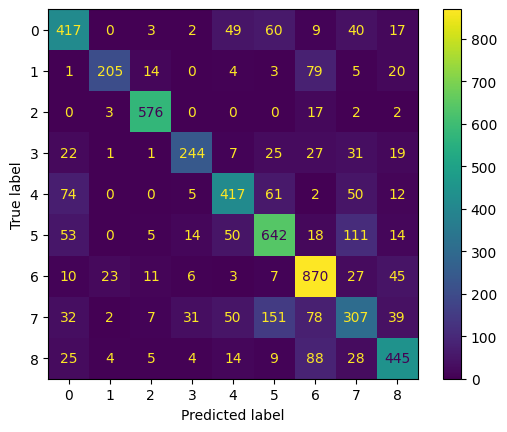

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_res, np.argmax(labels_l2_resampled, axis=1)):
    X_train, X_test = X_res[train_index], X_res[test_index]
    y_train, y_test = np.argmax(labels_l2_resampled[train_index], axis=1), np.argmax(labels_l2_resampled[test_index], axis=1)

   
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Display the results
print("Accuracies: ", accuracies)
print("Mean Accuracy: ", np.mean(accuracies))
print("F1 Scores: ", f1_scores)
print("Mean F1 Score: ", np.mean(f1_scores))

# Display the confusion matrix for the last fold
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


Fold 1
Fold 1 Accuracy: 0.7172
Fold 1 Macro F1: 0.7121
Fold 1 Weighted F1: 0.7134
Per-class F1 scores: {0: '0.6716', 1: '0.7601', 2: '0.9507', 3: '0.6616', 4: '0.6465', 5: '0.6764', 6: '0.8176', 7: '0.4938', 8: '0.7303'}

Fold 2
Fold 2 Accuracy: 0.6971
Fold 2 Macro F1: 0.6866
Fold 2 Weighted F1: 0.6925
Per-class F1 scores: {0: '0.6380', 1: '0.6655', 2: '0.9339', 3: '0.6543', 4: '0.6331', 5: '0.6560', 6: '0.8146', 7: '0.4716', 8: '0.7128'}

Fold 3
Fold 3 Accuracy: 0.7056
Fold 3 Macro F1: 0.7035
Fold 3 Weighted F1: 0.7022
Per-class F1 scores: {0: '0.6812', 1: '0.7504', 2: '0.9459', 3: '0.6925', 4: '0.6250', 5: '0.6582', 6: '0.8088', 7: '0.4506', 8: '0.7191'}

Fold 4
Fold 4 Accuracy: 0.7134
Fold 4 Macro F1: 0.7105
Fold 4 Weighted F1: 0.7099
Per-class F1 scores: {0: '0.6968', 1: '0.7428', 2: '0.9544', 3: '0.6945', 4: '0.6447', 5: '0.6756', 6: '0.8013', 7: '0.4754', 8: '0.7090'}

Fold 5
Fold 5 Accuracy: 0.7165
Fold 5 Macro F1: 0.7132
Fold 5 Weighted F1: 0.7130
Per-class F1 scores: {0: '0.6

<Figure size 1000x800 with 0 Axes>

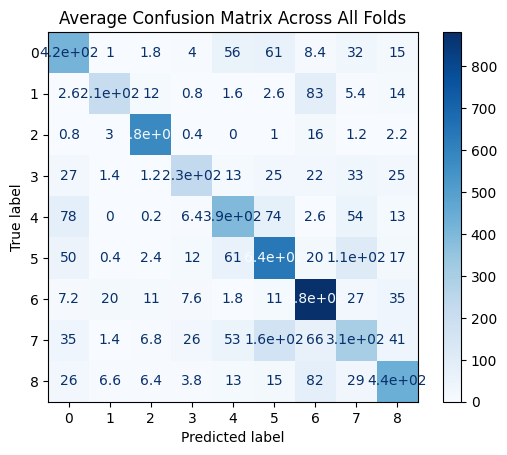

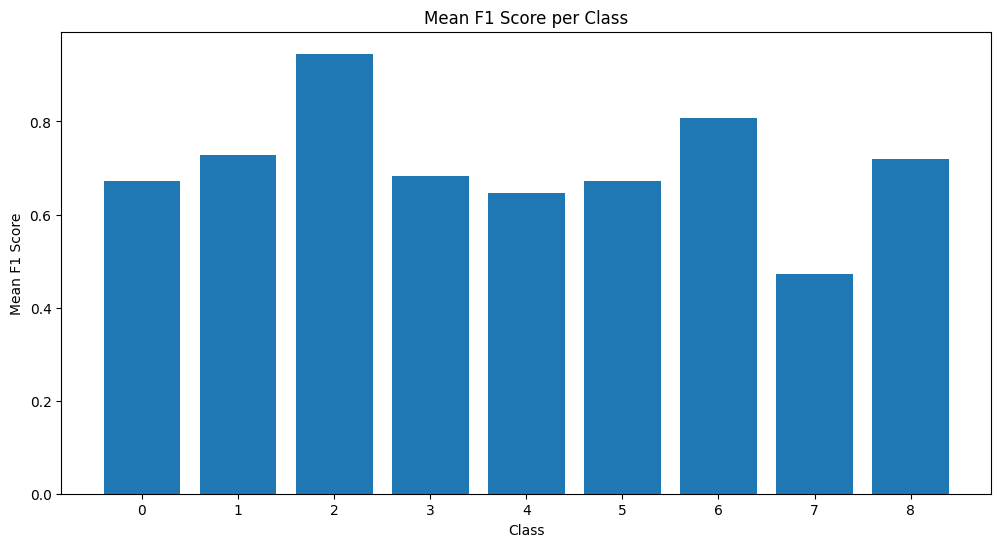

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []
per_class_f1 = []  # Add per-class metrics

# Perform Stratified K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(skf.split(X_res, np.argmax(labels_l2_resampled, axis=1)), 1):
    print(f"\nFold {fold}")
    
    X_train, X_test = X_res[train_index], X_res[test_index]
    y_train, y_test = np.argmax(labels_l2_resampled[train_index], axis=1), np.argmax(labels_l2_resampled[test_index], axis=1)
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced',
        n_jobs=-1  # Use all available cores
    )
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1_weighted)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    per_class_f1.append(f1_per_class)
    
    # Print fold results
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Macro F1: {f1_macro:.4f}")
    print(f"Fold {fold} Weighted F1: {f1_weighted:.4f}")
    print("Per-class F1 scores:", {i: f"{score:.4f}" for i, score in enumerate(f1_per_class)})

# Calculate and display final results
print("\nFinal Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
print(f"Mean Weighted F1: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")

# Calculate mean per-class F1 scores
mean_per_class_f1 = np.mean(per_class_f1, axis=0)
print("\nMean F1 score per class:")
for class_idx, f1 in enumerate(mean_per_class_f1):
    print(f"Class {class_idx}: {f1:.4f}")

# Plot confusion matrix (average across all folds)
plt.figure(figsize=(10, 8))
mean_cm = np.mean(confusion_matrices, axis=0)
ConfusionMatrixDisplay(
    confusion_matrix=mean_cm,
    display_labels=range(len(mean_per_class_f1))
).plot(cmap='Blues')
plt.title('Average Confusion Matrix Across All Folds')
plt.show()

# Plot F1 scores per class
plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_per_class_f1)), mean_per_class_f1)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score per Class')
plt.xticks(range(len(mean_per_class_f1)))
plt.show()

The results above has shown good improvements in the accuracy measeures (0.4 -> 0.7). However, since the current step is the midway of the tree species clasification, much higher accuracy at this stage is expected. For this reason, at least improving the accuracy to 0.9 is aimed. Further SMOTE and weight adjustment are implemented below for the classes 1 and 3 must help improving acucracy.


The increasse in f1 score of class 2 and decrease at the neighbouring classes indicated the increased sample size of class 2 make the boundaries between classes more differentiatable for the model. This suggest more investiagtion towards sample sizes and class weights of training dataset may improve the accuracy further. If the f1 score of class 2 is achieved at all the samples, then we have a strong case for specie type classificaitpn.

In [26]:
X.shape, labels_l2.shape

((26268, 1000), (26268, 9))

Just for experimental purposes making all the class sizes equal to 5000.

In [92]:
from imblearn.over_sampling import SMOTE

# Create a dictionary for multiple classes
sampling_strategy = {
    0: 5000,
    1: 5000,
    2: 5000,  # Keep current strategy for class 2
    3: 5000,
    7: 7000,  # Add sampling for worst performing class (F1: 0.4754)
    4: 6000,   # Add sampling for class with declining performance
    8: 5000,
    5: 7000
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, np.argmax(labels_l2, axis=1))

# Update the labels_l2 with the resampled data
labels_l2_resampled = encoder.fit_transform(y_resampled.reshape(-1, 1))

(array([5000.,    0., 5000.,    0., 5000.,    0., 5000.,    0., 6000.,
           0., 7000.,    0., 5012.,    0., 7000.,    0., 5000.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

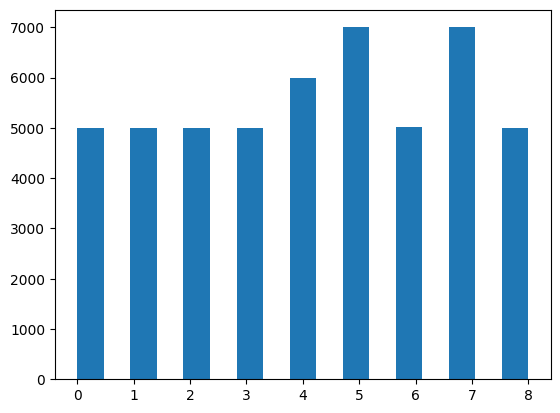

In [ ]:
# Check the data distribution
plt.hist(np.argmax(labels_l2_resampled, axis=1), bins=17)

In [28]:
from sklearn.model_selection import StratifiedKFold, learning_curve
def plot_learning_curves(estimator, X, y):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [29]:
import time
from sklearn.model_selection import GridSearchCV

# Add timing
start_time = time.time()

# Define parameter grid for tree classification
param_grid = {
    'n_estimators': [100],  # Number of trees
    'max_depth': [15],  # Tree depth
    'min_samples_split': [12],  # Minimum samples required to split
    'min_samples_leaf': [4],  # Minimum samples required at leaf node
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_features': ['sqrt', 'log2'],  # Number of features to consider
}

# Initialize base classifier
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")
# Fit grid search
grid_search.fit(X_resampled, np.argmax(labels_l2_resampled, axis=1))

# Get best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Execution time: 0.00 seconds
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}


Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}


Fold 1
Fold 1 Training Accuracy: 0.9782
Fold 1 Validation Accuracy: 0.8234
Fold 1 Training Weighted F1: 0.9782
Fold 1 Validation Weighted F1: 0.8236
Per-class F1 scores: {0: '0.8039', 1: '0.8830', 2: '0.9518', 3: '0.8751', 4: '0.8244', 5: '0.7943', 6: '0.7984', 7: '0.7302', 8: '0.8000'}

Fold 2
Fold 2 Training Accuracy: 0.9787
Fold 2 Validation Accuracy: 0.8152
Fold 2 Training Weighted F1: 0.9787
Fold 2 Validation Weighted F1: 0.8154
Per-class F1 scores: {0: '0.7874', 1: '0.8879', 2: '0.9452', 3: '0.8677', 4: '0.8018', 5: '0.7907', 6: '0.7998', 7: '0.7075', 8: '0.8063'}

Fold 3
Fold 3 Training Accuracy: 0.9783
Fold 3 Validation Accuracy: 0.8182
Fold 3 Training Weighted F1: 0.9783
Fold 3 Validation Weighted F1: 0.8184
Per-class F1 scores: {0: '0.7929', 1: '0.8883', 2: '0.9602', 3: '0.8692', 4: '0.7940', 5: '0.7809', 6: '0.7971', 7: '0.7277', 8: '0.8116'}

Fold 4
Fold 4 Training Accuracy: 0.9776
Fold 4 Validation Accuracy: 0.8126
Fold 4 Training Weighted F1: 0.9775
Fold 4 Validation Wei

<Figure size 1000x800 with 0 Axes>

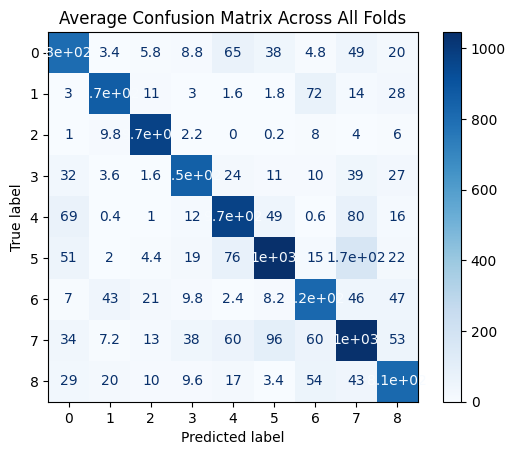

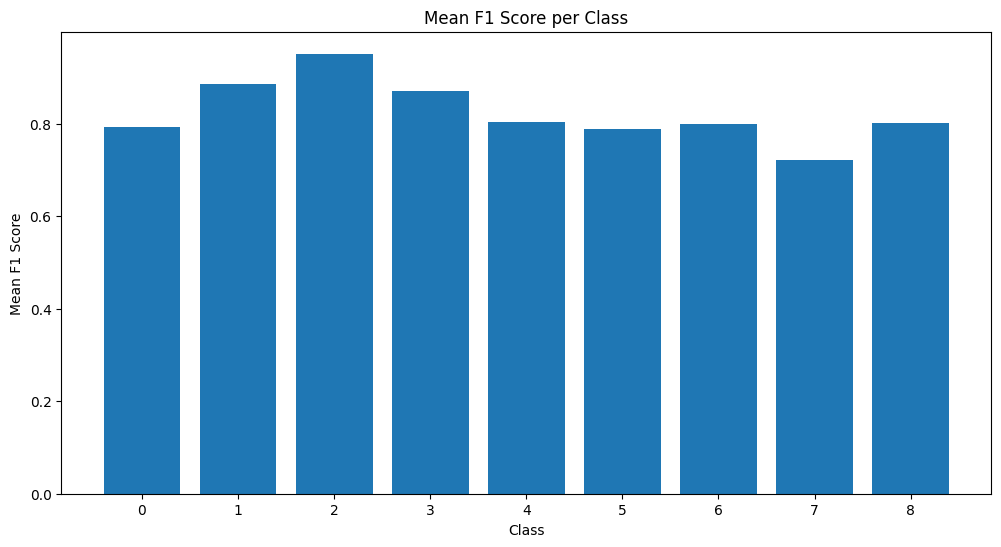

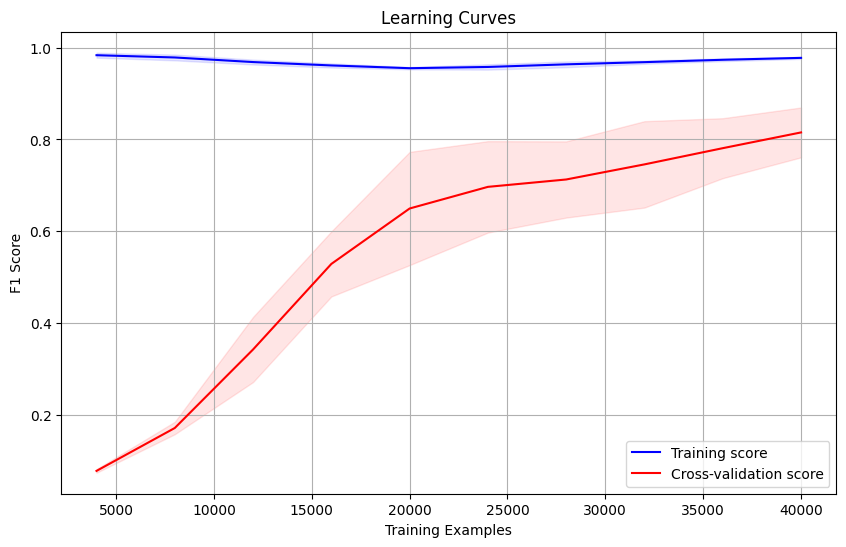

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV




# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
confusion_matrices = []
per_class_f1 = []  # Add per-class metrics

# Perform Stratified K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(skf.split(X_resampled, np.argmax(labels_l2_resampled, axis=1)), 1):
    print(f"\nFold {fold}")
    
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = np.argmax(labels_l2_resampled[train_index], axis=1), np.argmax(labels_l2_resampled[test_index], axis=1)
    
    # Train the Random Forest Classifier with regularization
    rf_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=best_params['n_estimators'],
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_jobs=-1
)
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = rf_classifier.predict(X_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate metrics for training set
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
    
    # Calculate metrics for test set
    val_acc = accuracy_score(y_test, y_pred)
    val_f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Store the results
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1_weighted)
    val_f1_scores.append(val_f1_weighted)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    per_class_f1.append(f1_per_class)
    
    # Print fold results
    print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
    print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")
    print(f"Fold {fold} Training Weighted F1: {train_f1_weighted:.4f}")
    print(f"Fold {fold} Validation Weighted F1: {val_f1_weighted:.4f}")
    print("Per-class F1 scores:", {i: f"{score:.4f}" for i, score in enumerate(f1_per_class)})

# Calculate and display final results
print("\nFinal Results:")
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (±{np.std(train_accuracies):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (±{np.std(val_accuracies):.4f})")
print(f"Mean Training Weighted F1: {np.mean(train_f1_scores):.4f} (±{np.std(train_f1_scores):.4f})")
print(f"Mean Validation Weighted F1: {np.mean(val_f1_scores):.4f} (±{np.std(val_f1_scores):.4f})")

# Calculate mean per-class F1 scores
mean_per_class_f1 = np.mean(per_class_f1, axis=0)
print("\nMean F1 score per class:")
for class_idx, f1 in enumerate(mean_per_class_f1):
    print(f"Class {class_idx}: {f1:.4f}")

# Plot confusion matrix (average across all folds)
plt.figure(figsize=(10, 8))
mean_cm = np.mean(confusion_matrices, axis=0)
ConfusionMatrixDisplay(
    confusion_matrix=mean_cm,
    display_labels=range(len(mean_per_class_f1))
).plot(cmap='Blues')
plt.title('Average Confusion Matrix Across All Folds')
plt.show()

# Plot F1 scores per class
plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_per_class_f1)), mean_per_class_f1)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score per Class')
plt.xticks(range(len(mean_per_class_f1)))
plt.show()

plot_learning_curves(
    rf_classifier,
    X_resampled,
    np.argmax(labels_l2_resampled, axis=1)
)

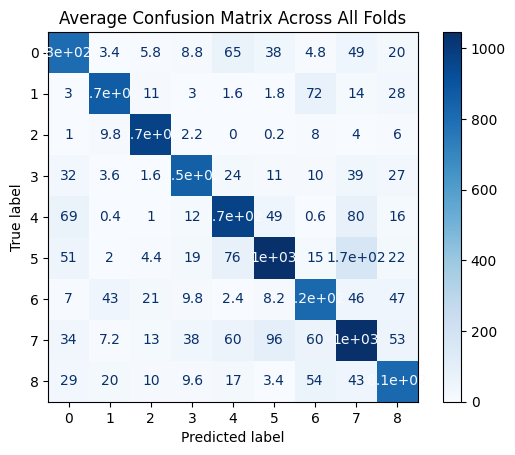

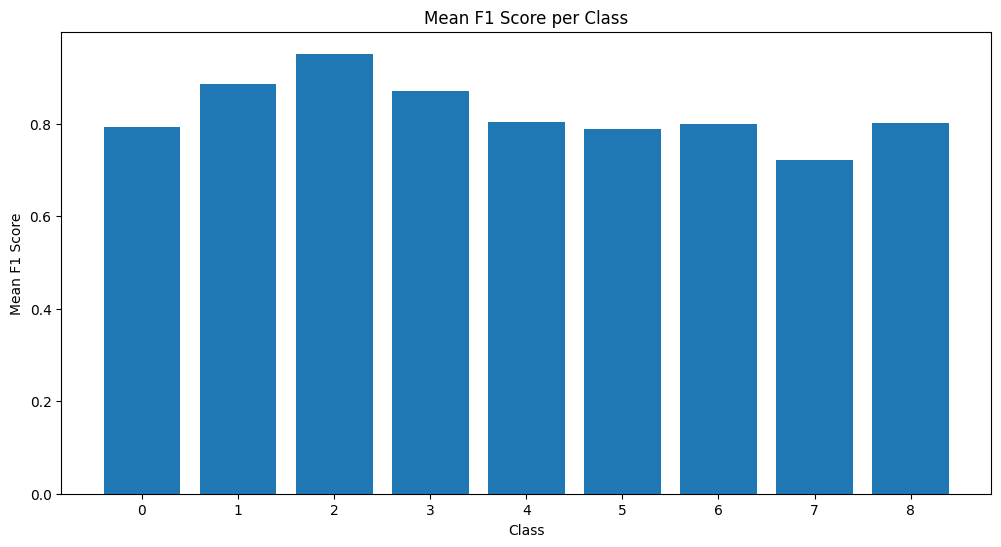

The previous learning curves before gridsearchcv:

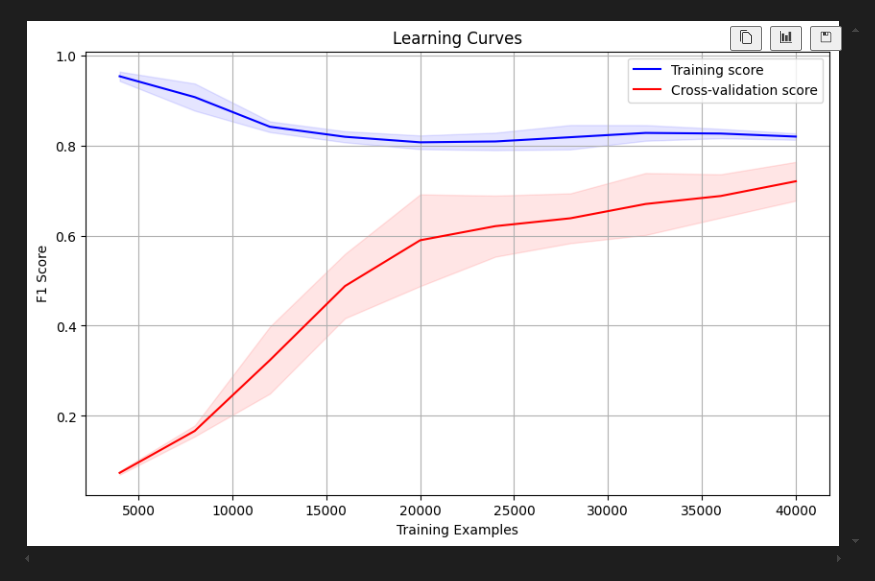

After adjustment with gridsearchcv against overfitting

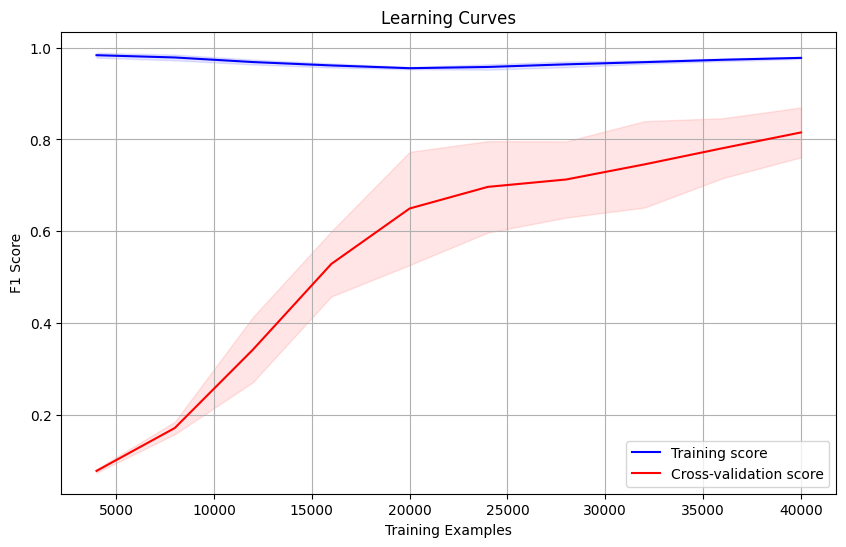

The results above very crucially showed that when the sample sizes are equal (5000 sample count), the classification between classes such as 4, 5, 6, 7 amd 8 are revealed to be more complex. It suggests decision boundaries are more complex or data augmentation method might result too muchr epeating values while untouvhed samples have higher variations. This is the reason that the results have first classes well classified but not the rest. The soltion might be with future engineering or different model architectures.

In [94]:
X_resampled.shape, y_resampled.shape, labels_l2_resampled.shape


((50012, 1000), (50012,), (50012, 9))

(array([5000.,    0., 5000.,    0., 5000.,    0., 5000.,    0., 6000.,
           0., 7000.,    0., 5012.,    0., 7000.,    0., 5000.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

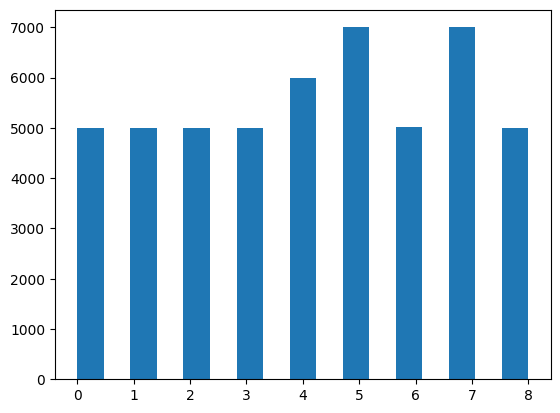

In [96]:
plt.hist(np.argmax(labels_l2_resampled, axis=1), bins=17)

In this section, the labeled data set is shuffled and equal number of species are choosen from each class for training and testing. This way variations between class features might be normailized a little more and training might become more effective.

Using resnet50 keras pretrained model for comparison with random forest accuracy.

In [98]:
X_resampled.shape, y_resampled.shape, labels_l2_resampled.shape

((50012, 1000), (50012,), (50012, 9))

In [147]:
import tensorflow as tf
def pre_unet_model(input_size=(5, 5, 40)):
    inputs = tf.keras.layers.Input(shape=input_size)
    # get here the pretrained model like modelnetv2 or other
    #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)


    # Initial convolutions to process 40 channels to create meaningful features
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    # Reduce channels while maintaining spatial dimensions
    x = tf.keras.layers.Conv2D(3, 1, padding='same')(x)  # Reduce to 3 channels for MobileNetV2
    
    # Resize to 32x32 to meet MobileNetV2 requirements
    x = tf.keras.layers.Resizing(32, 32)(x)
    
    # Pre-trained MobileNetV2 model
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
    
    # Pass the processed input through the pre-trained model
    x = pretrained_model(x)
    
    # Store skip connections
    skip1 = x  # First skip connection (5x5)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    skip2 = x  # Second skip connection (5x5)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    # Bridge
    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Decoder path with skip connections
    x = tf.keras.layers.UpSampling2D((1, 1))(x)
    x = tf.keras.layers.Concatenate()([x, skip2])
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.UpSampling2D((1, 1))(x)
    x = tf.keras.layers.Concatenate()([x, skip1])
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Final convolution to match output classes
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Conv2D(17, 1, padding='same', activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and display the model
pre_unet = pre_unet_model()
pre_unet.summary()

C:\Users\berky\AppData\Local\Temp\ipykernel_13492\778581096.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 5, 5, 40)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 5, 5, 64)  │     23,104 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 5, 5, 3)   │        195 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 32, 32, 3) │          0 │ conv2d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1, 1,      │  2,257,984 │ resizing[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 1, 1, 128) │  1,474,688 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 128) │        512 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 1, 1, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 1, 1, 256) │    295,168 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 256) │      1,024 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 1, 1, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 1, 1, 512) │  1,180,160 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 512) │      2,048 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 1, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_14    │ (None, 1, 1, 512) │          0 │ dropout_2[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 1, 1, 640) │          0 │ up_sampling2d_14… │
│ (Concatenate)       │                   │            │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 1, 1, 256) │  1,474,816 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,556,244 (32.64 MB)

 Trainable params: 8,519,316 (32.50 MB)

 Non-trainable params: 36,928 (144.25 KB)

In [148]:
X_resampled.shape, y_resampled.shape, labels_l2_resampled[0][0]


((50012, 1000), (50012,), 1.0)

In [150]:
# Get the number of samples
n_samples = X_resampled.shape[0]

# Calculate the number of channels/features (m)
# Since each sample has a 5x5 grid, m = 1000 / (5*5) = 40
m_channels = X_resampled.shape[1] // (5 * 5)

# Reshape the data to (n_samples, 5, 5, m_channels)
X_reshaped = X_resampled.reshape(n_samples, 5, 5, m_channels)

print(f"Reshaped data dimensions: {X_reshaped.shape}")

Reshaped data dimensions: (50012, 5, 5, 40)


In [151]:
print(X_reshaped.shape)
print(labels_l2_resampled.shape)

(50012, 5, 5, 40)
(50012, 9)


In [154]:
# Create an instance of the model
pre_unet = pre_unet_model()

# Assuming X_reshaped is your input data with the correct shape
# Verify the shape of the input data
print("Input shape:", X_reshaped.shape)

# Use the model instance to make predictions
yz_pre_unet = pre_unet.predict(X_reshaped)

# Print the shape of the predictions
print("Predictions shape:", yz_pre_unet.shape)


C:\Users\berky\AppData\Local\Temp\ipykernel_13492\778581096.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


Input shape: (50012, 5, 5, 40)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step
Predictions shape: (50012, 1, 1, 17)


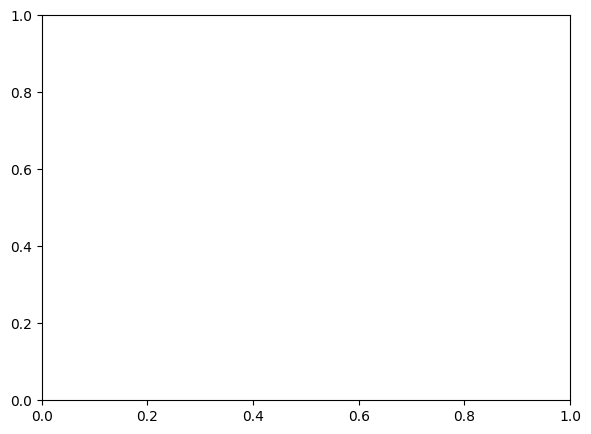

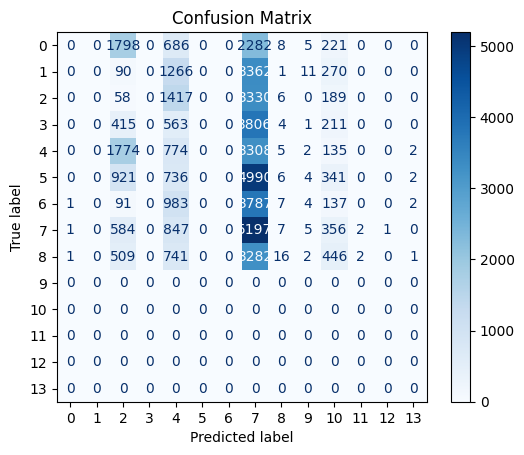

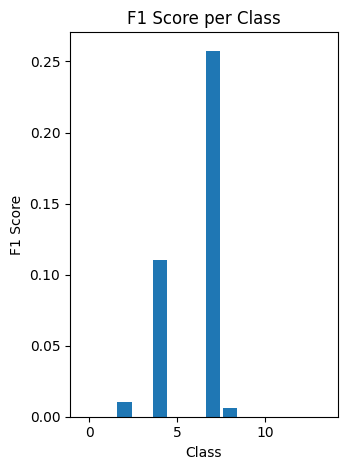

Overall Accuracy: 0.1209
Weighted F1 Score: 0.0510

Per-class F1 Scores:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0103
Class 3: 0.0000
Class 4: 0.1105
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.2576
Class 8: 0.0063
Class 9: 0.0000
Class 10: 0.0000
Class 11: 0.0000
Class 12: 0.0000
Class 13: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5000
           1       0.00      0.00      0.00      5000
           2       0.01      0.01      0.01      5000
           3       0.00      0.00      0.00      5000
           4       0.10      0.13      0.11      6000
           5       0.00      0.00      0.00      7000
           6       0.00      0.00      0.00      5012
           7       0.16      0.74      0.26      7000
           8       0.27      0.00      0.01      5000
           9       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00   

c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\dseo\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\berky\.conda\envs\

In [156]:
# Convert predictions to class labels
yz_pre_unet_int = np.argmax(yz_pre_unet.reshape(yz_pre_unet.shape[0], -1), axis=1)

# Calculate metrics comparing with y_resampled
accuracy = accuracy_score(y_resampled, yz_pre_unet_int)
f1 = f1_score(y_resampled, yz_pre_unet_int, average='weighted')
conf_matrix = confusion_matrix(y_resampled, yz_pre_unet_int)

# Create figure with subplots
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix
plt.subplot(1, 2, 1)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot 2: Bar chart of class-wise F1 scores
plt.subplot(1, 2, 2)
class_f1 = f1_score(y_resampled, yz_pre_unet_int, average=None)
plt.bar(range(len(class_f1)), class_f1)
plt.title('F1 Score per Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Print metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nPer-class F1 Scores:")
for i, score in enumerate(class_f1):
    print(f"Class {i}: {score:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_resampled, yz_pre_unet_int))

In [157]:
pre_unet.layers[2].trainable = False
pre_unet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 5, 5, 40)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 5, 5, 64)  │     23,104 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 5, 5, 3)   │        195 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 32, 32, 3) │          0 │ conv2d_60[0][0]   │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 1, 1,      │  2,257,984 │ resizing_1[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 1, 1, 128) │  1,474,688 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 128) │        512 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 1, 1, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 1, 1, 256) │    295,168 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 256) │      1,024 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 1, 1, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 1, 1, 512) │  1,180,160 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 512) │      2,048 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 1, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 1, 1, 512) │          0 │ dropout_3[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 1, 1, 640) │          0 │ up_sampling2d_16… │
│ (Concatenate)       │                   │            │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 1, 1, 256) │  1,474,816 │ concatenate_18[0

 Total params: 8,556,244 (32.64 MB)

 Trainable params: 8,519,188 (32.50 MB)

 Non-trainable params: 37,056 (144.75 KB)

In [158]:
inputs = tf.keras.layers.Input(shape=(5, 5, 40))
x = pre_unet(inputs)
x = tf.keras.layers.Conv2D(7, (1, 1), padding="same")(x)
x = tf.keras.layers.Activation("softmax")(x)

transfer_model = tf.keras.Model(inputs, x)

transfer_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 5, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 1, 1, 17)       │     8,556,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 1, 1, 7)        │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1, 1, 7)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,556,370 (32.64 MB)

 Trainable params: 8,519,314 (32.50 MB)

 Non-trainable params: 37,056 (144.75 KB)

This part below is the last pretraining transfer model implementation I did. The cnn needs more epochs to reach a good accuracy. Then it might be well trained for l2 labels.

In [162]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

def pre_unet_model(input_size=(5, 5, 40)):
    inputs = tf.keras.layers.Input(shape=input_size)
    
    # Initial convolutions to process 40 channels to create meaningful features
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    # Reduce channels while maintaining spatial dimensions
    x = tf.keras.layers.Conv2D(3, 1, padding='same')(x)  # Reduce to 3 channels for MobileNetV2
    
    # Resize to 32x32 to meet MobileNetV2 requirements
    x = tf.keras.layers.Resizing(32, 32)(x)
    
    # Pre-trained MobileNetV2 model
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
    
    # Freeze the pre-trained model layers
    pretrained_model.trainable = False
    
    # Pass the processed input through the pre-trained model
    x = pretrained_model(x)
    
    # Store skip connections
    skip1 = x  # First skip connection (8x8)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    skip2 = x  # Second skip connection (8x8)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(1, 1), padding='same')(x)
    
    # Bridge
    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Decoder path with skip connections
    x = tf.keras.layers.UpSampling2D((1, 1))(x)
    x = tf.keras.layers.Concatenate()([x, skip2])
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.UpSampling2D((1, 1))(x)
    x = tf.keras.layers.Concatenate()([x, skip1])
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Final convolution to match output classes
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Conv2D(17, 1, padding='same', activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create an instance of the model
pre_unet = pre_unet_model()

# Define the transfer model
inputs = tf.keras.layers.Input(shape=(5, 5, 40))
x = pre_unet(inputs)
# Add Global Average Pooling to reduce spatial dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add Dense layer for classification
# Increase the number of units to match the number of unique classes
x = tf.keras.layers.Dense(9, activation="softmax")(x)  # Changed from 7 to 9 to accommodate classes 0-8

transfer_model = tf.keras.Model(inputs, x)

# Compile the transfer model
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
transfer_model.summary()


# Calculate sizes for train/val/test splits
train_size = 0.7
val_size = 0.15
# test_size will be the remaining 0.15

# First split into train and temp (val+test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=1-(train_size), 
    random_state=42, 
    stratify=y_resampled
)

# Split temp into validation and test
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=val_size/(train_size+val_size),
    random_state=42,
    stratify=y_train_temp
)

# Reshape the data if needed
if len(X_train.shape) == 2:
    n_samples = X_train.shape[0]
    m_channels = X_train.shape[1] // (5 * 5)
    X_train = X_train.reshape(n_samples, 5, 5, m_channels)
    X_val = X_val.reshape(X_val.shape[0], 5, 5, m_channels)
    X_test = X_test.reshape(X_test.shape[0], 5, 5, m_channels)

# Train the model
history = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

# Evaluate the model
val_loss, val_accuracy = transfer_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

C:\Users\berky\AppData\Local\Temp\ipykernel_13492\201328125.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 5, 5, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_14 (Functional)      │ (None, 1, 1, 17)       │     8,556,244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 17)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,556,406 (32.64 MB)

 Trainable params: 6,295,606 (24.02 MB)

 Non-trainable params: 2,260,800 (8.62 MB)

Epoch 1/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 108s 112ms/step - accuracy: 0.2041 - loss: 2.0499 - val_accuracy: 0.2520 - val_loss: 1.9695
Epoch 2/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 105s 117ms/step - accuracy: 0.2856 - loss: 1.8202 - val_accuracy: 0.2373 - val_loss: 1.9277
Epoch 3/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 104s 116ms/step - accuracy: 0.3119 - loss: 1.7192 - val_accuracy: 0.3509 - val_loss: 1.6218
Epoch 4/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 106s 118ms/step - accuracy: 0.3389 - loss: 1.6489 - val_accuracy: 0.3747 - val_loss: 1.5957
Epoch 5/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 105s 117ms/step - accuracy: 0.3786 - loss: 1.5858 - val_accuracy: 0.3669 - val_loss: 1.6347
Epoch 6/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 106s 118ms/step - accuracy: 0.4004 - loss: 1.5300 - val_accuracy: 0.4013 - val_loss: 1.5034
Epoch 7/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 106s 118ms/step - accuracy: 0.4223 - loss: 1.4989 - val_accuracy: 0.4142 - val_loss: 1.4999
Epoch 8/15
901/901 ━━━━━━━━━━━━━━━━━━━━ 105s 117ms/step - accuracy: 0.4186 -

# Reshape the data to fit the CNN input requirements
X_train_cnn = X_train
X_test_cnn = X_test

# reshape data to a 4d
try:
    arr_4d_xtrain = X_train.reshape(-1, 40, 5, 5)
    print(arr_4d_xtrain.shape)
except Exception as e:
    print("Error:", e)


# reshape data to a 4d
try:
    arr_4d_xtest = X_test.reshape(-1, 40, 5, 5)
    print(arr_4d_xtest.shape)
except Exception as e:
    print("Error:", e)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
import numpy as np

# Data preparation
# Reshape the data to fit the CNN input requirements
X_train_cnn = np.expand_dims(arr_4d_xtrain, axis=-1)  # Ensure data shape is (samples, 40, 5, 5, 1)
X_test_cnn = np.expand_dims(arr_4d_xtest, axis=-1)

# Convert labels to categorical
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_test_cnn = tf.keras.utils.to_categorical(y_test)

# Define the CNN model
inputs = keras.Input(shape=(40, 5, 5, 1))

# TimeDistributed Convolutional Layers
x = TimeDistributed(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))(inputs)
x = TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))(x)
x = TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'))(x)
x = TimeDistributed(layers.Flatten())(x)

# LSTM for temporal feature extraction
x = layers.LSTM(128, return_sequences=False)(x)

# Fully connected layers with Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(y_train_cnn.shape[1], activation='softmax')(x)

# Build and compile the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add data augmentation (optional, depending on task)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Training the model
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cnn)
)

# Evaluate the model
score = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training and validation accuracy/loss (for better insight)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Analysis of the Graphs
1. Model Accuracy (Left Panel):
The training accuracy steadily increases throughout the 30 epochs, nearing 90% by the end.
The validation accuracy improves significantly until around epoch 15, where it begins to fluctuate and plateaus around 80%.
The gap between training and validation accuracy widens slightly after epoch 15, indicating potential overfitting.
2. Model Loss (Right Panel):
The training loss continuously decreases, reflecting consistent improvement in the model's ability to fit the training data.
The validation loss decreases until around epoch 15, after which it fluctuates and shows signs of stagnation or slight increase.
The divergence between training and validation loss in the later epochs also suggests overfitting.
Key Observations:
The optimal epoch range for this model appears to be around 15-20 epochs.
After epoch 15:
Validation accuracy fluctuates and doesn't improve significantly.
Validation loss increases intermittently, indicating that the model begins to overfit to the training data.
Recommendations:
Early Stopping: Use early stopping with a patience of 3-5 epochs based on validation loss to automatically halt training when overfitting begins.

Regularization:

Introduce dropout or L2 regularization to prevent overfitting and allow the model to generalize better.
Learning Rate Scheduler: Lower the learning rate after epoch 15 to stabilize training and prevent oscillations.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data preparation
# Reshape the data to fit the CNN input requirements
X_train_cnn = np.expand_dims(arr_4d_xtrain, axis=-1)  # Ensure data shape is (samples, 40, 5, 5, 1)
X_test_cnn = np.expand_dims(arr_4d_xtest, axis=-1)

# Convert labels to categorical
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_test_cnn = tf.keras.utils.to_categorical(y_test)



# Define the CNN model
inputs = keras.Input(shape=(40, 5, 5, 1))

# TimeDistributed Convolutional Layers
x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))(inputs)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = layers.TimeDistributed(layers.Conv2D(128, kernel_size=(2, 2), activation='relu', padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

# LSTM for temporal feature extraction
x = layers.LSTM(128, return_sequences=False)(x)

# Fully connected layers with Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(y_train_cnn.shape[1], activation='softmax')(x)

# Build and compile the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Training the model with EarlyStopping
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=16,
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

# Evaluate the model
score = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training and validation accuracy/loss (for better insight)
plt.figure(figsize=(12, 4))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


At this part l3 species classification starts

In [50]:
labels_raw = np.array(combined_gdf_cleaned['l3_species'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l3 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l3[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l3_species'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l3_species'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l3_species'].value_counts())

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique species in first 19 samples:
['european beech']

All unique species:
['european beech' 'linden' 'cherry' 'sycamore maple' 'european ash'
 'english oak' 'sessile oak' 'red oak' 'alder' 'poplar' 'birch'
 'douglas fir' 'silver fir' 'japanese larch' 'european larch' 'black pine'
 'weymouth pine' 'norway spruce' 'scots pine']

Species distribution:
l3_species
scots pine        4260
norway spruc

(array([3189.,  311.,  152., 1657., 2070., 1483., 2989.,  782., 1102.,
         125., 3107.,  296., 1116., 4260., 1345.,  498., 1786.]),
 array([ 0.        ,  1.05882353,  2.11764706,  3.17647059,  4.23529412,
         5.29411765,  6.35294118,  7.41176471,  8.47058824,  9.52941176,
        10.58823529, 11.64705882, 12.70588235, 13.76470588, 14.82352941,
        15.88235294, 16.94117647, 18.        ]),
 <BarContainer object of 17 artists>)

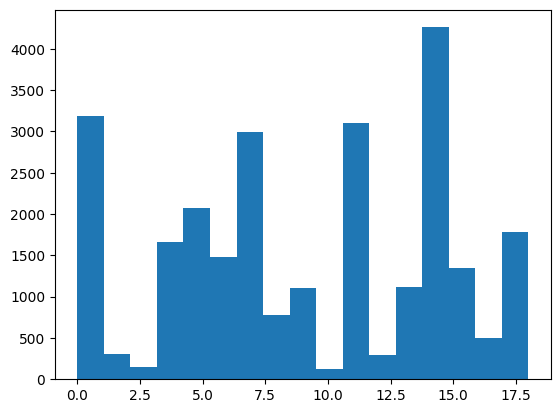

In [51]:
# Check the data distribution
plt.hist(np.argmax(labels_l3, axis=1), bins=17)

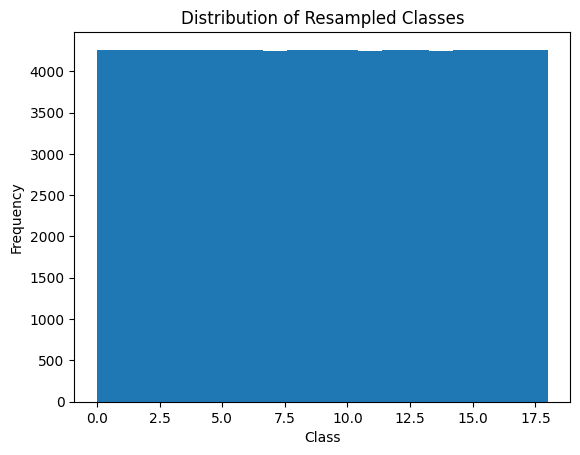

Accuracies:  [0.9068372898120672, 0.9026893353941268, 0.9040494590417311, 0.9006491499227203, 0.8999072642967543]
Mean Accuracy:  0.9028264996934798
F1 Scores:  [0.9064485549889835, 0.9025560489259783, 0.9035818697911131, 0.9004923137057664, 0.8996484226510202]
Mean F1 Score:  0.9025454420125725


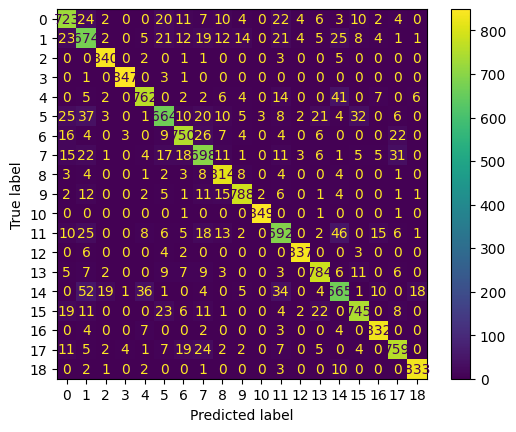

In [89]:
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder

# Apply SMOTETomek to balance the classes
smote_tomek = SMOTETomek(random_state=42)
X_resampled_l3, y_resampled_l3 = smote_tomek.fit_resample(X, np.argmax(labels_l3, axis=1))

# Update the labels_l3 with the resampled data
encoder = OneHotEncoder(sparse_output=False)
labels_l3_resampled = encoder.fit_transform(y_resampled_l3.reshape(-1, 1))

# Check the data distribution
plt.hist(np.argmax(labels_l3_resampled, axis=1), bins=len(np.unique(y_resampled_l3)))
plt.title('Distribution of Resampled Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_resampled_l3, np.argmax(labels_l3_resampled, axis=1)):
    X_train, X_test = X_resampled_l3[train_index], X_resampled_l3[test_index]
    y_train, y_test = np.argmax(labels_l3_resampled[train_index], axis=1), np.argmax(labels_l3_resampled[test_index], axis=1)
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Display the results
print("Accuracies: ", accuracies)
print("Mean Accuracy: ", np.mean(accuracies))
print("F1 Scores: ", f1_scores)
print("Mean F1 Score: ", np.mean(f1_scores))

# Display the confusion matrix for the last fold
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Using keras resnet50 pretrained model for comparison with random forest classificaiton

In [90]:
print(X_resampled_l3.shape, y_resampled_l3.shape,labels_l3_resampled.shape)

(80876, 1000) (80876,) (80876, 19)


Labels shape: (80876, 19)
X resampled shape: (80876, 1000)
y resampled shape: (80876,)
L2 predictions shape: (16175,)
Combined shape: (80876, 1001)
Predictions shape:  (80876, 1)


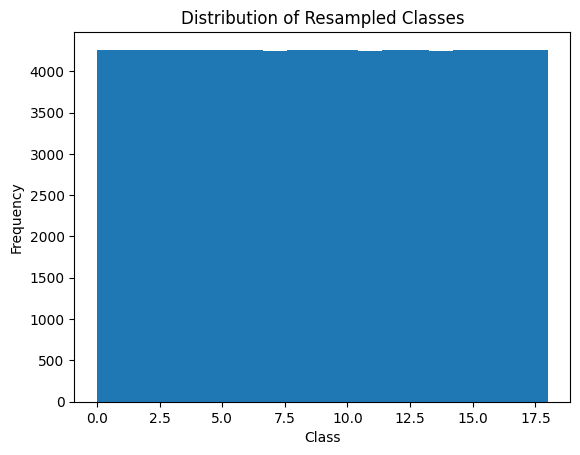

In [59]:
# Check the data distribution
print("Labels shape:", labels_l3_resampled.shape)
print("X resampled shape:", X_resampled_l3.shape)
print("y resampled shape:", y_resampled_l3.shape)
print("L2 predictions shape:", y_pred.shape)

# Ensure l2_predictions has the same number of rows as X_resampled_l3
if len(y_pred) < len(X_resampled_l3):
	# If l2_predictions is smaller, repeat it to match X_resampled_l3's size
	repeat_times = len(X_resampled_l3) // len(y_pred) + 1
	l2_predictions = np.tile(y_pred, repeat_times)[:len(X_resampled_l3)]
else:
	# If l2_predictions is larger, truncate it to match X_resampled_l3's size
	l2_predictions = y_pred[:len(X_resampled_l3)]

l2_predictions = l2_predictions.reshape(-1, 1)  # Reshape to column vector
X_resampled_l3_with_l2 = np.hstack((X_resampled_l3, l2_predictions))
print("Combined shape:", X_resampled_l3_with_l2.shape)
print("Predictions shape: ", l2_predictions.shape) #Predictions shape:  (16175,)
plt.hist(np.argmax(labels_l3_resampled, axis=1), bins=len(np.unique(y_resampled_l3)))
plt.title('Distribution of Resampled Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

The model below is tree species predictive model training has the following workflow;
Custom Transformer: The DataAugmenter class is a custom transformer that adds Gaussian noise to the input data. This can help in augmenting the dataset and potentially improving model robustness.

Ensemble Classifier: The create_ensemble function defines an ensemble classifier using VotingClassifier from scikit-learn. It combines three different classifiers: RandomForestClassifier, XGBClassifier, and LGBMClassifier. The ensemble uses soft voting, which means it averages the predicted probabilities of the individual classifiers.

Training Pipeline: The train_species_classifier function is the main training pipeline. It performs the following steps:

Data Preparation: It encodes the labels using OneHotEncoder if they are not already in class index form.
Train-Validation Split: It splits the data into training and validation sets using train_test_split.
Pipeline Creation: It creates a pipeline that includes standard scaling, data augmentation, resampling using SMOTETomek, and the ensemble classifier.
Cross-Validation: It performs stratified k-fold cross-validation to evaluate the model. It stores accuracy, F1 scores, confusion matrices, and feature importances for each fold.
Validation: It evaluates the model on the held-out validation set and returns the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

# Custom transformer for feature augmentation
class DataAugmenter(BaseEstimator, TransformerMixin):
    def __init__(self, noise_level=0.01):
        self.noise_level = noise_level
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        noise = np.random.normal(0, self.noise_level, X.shape)
        return X + noise

# Function to create ensemble classifier
def create_ensemble():
    return VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                class_weight='balanced',
                random_state=42
            )),
            ('xgb', XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )),
            ('lgb', LGBMClassifier(
                n_estimators=200,
                num_leaves=31,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )),
            ('nn', MLPClassifier(
                hidden_layer_sizes=(100, 50),
                max_iter=300,
                random_state=42
            )),
            ('gb', GradientBoostingClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            ))
        ],
        voting='soft'
    )

# Main training pipeline
def train_species_classifier(X, labels_l3, test_size=0.15, n_splits=5):
    # Prepare the data
    encoder = OneHotEncoder(sparse_output=False)
    if labels_l3.ndim == 1:
        y = labels_l3  # If 1D, assume it's already the class indices
    else:
        y = np.argmax(labels_l3, axis=1)
    
    # Ensure X and y have the same number of samples
    if len(X) != len(y):
        min_samples = min(len(X), len(y))
        X = X[:min_samples]
        y = y[:min_samples]
    
    # Split into train and validation sets before SMOTE
    X_train_full, X_val, y_train_full, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    # Combine spectral features with genus predictions
    #X_train_full = np.hstack([X_train_full, genus_predictions[:-len(X_val)]])
    #X_val = np.hstack([X_val, genus_predictions[-len(X_val):]])
    
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('augmenter', DataAugmenter(noise_level=0.01)),
        ('sampler', SMOTETomek(random_state=42)),
        ('classifier', create_ensemble())
    ])
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Arrays to store results
    accuracies = []
    f1_scores = []
    confusion_matrices = []
    feature_importances = []
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Training fold {fold + 1}/{n_splits}")
        
        X_train, X_test = X_train_full[train_idx], X_train_full[test_idx]
        y_train, y_test = y_train_full[train_idx], y_train_full[test_idx]
        
        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Store metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        
        # Store feature importances from Random Forest
        if hasattr(pipeline.named_steps['classifier'], 'named_estimators_'):
            rf = pipeline.named_steps['classifier'].named_estimators_['rf']
            feature_importances.append(rf.feature_importances_)
    
    # Validate on held-out set
    val_pred = pipeline.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred, average='weighted')
    
    return {
        'pipeline': pipeline,
        'cv_accuracies': accuracies,
        'cv_f1_scores': f1_scores,
        'confusion_matrices': confusion_matrices,
        'feature_importances': feature_importances,
        'validation_accuracy': val_accuracy,
        'validation_f1': val_f1
    }

# Function to plot results
def plot_results(results):
    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    last_cm = results['confusion_matrices'][-1]
    ConfusionMatrixDisplay(confusion_matrix=last_cm).plot()
    plt.title('Confusion Matrix (Last Fold)')
    plt.show()
    
    # Plot feature importances
    if results['feature_importances']:
        plt.figure(figsize=(12, 6))
        mean_importance = np.mean(results['feature_importances'], axis=0)
        plt.bar(range(len(mean_importance)), mean_importance)
        plt.title('Feature Importance (Random Forest)')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()
    
    # Print metrics
    print("\nResults Summary:")
    print(f"Cross-validation Accuracy: {np.mean(results['cv_accuracies']):.4f} ± {np.std(results['cv_accuracies']):.4f}")
    

print("Predictions shape: ", l2_predictions.shape) #Predictions shape:  (16175,)
print("Labels shape: ", labels_l3.shape) # Labels shape:  (1000,)
print("x shape: ", X_resampled.shape) #x shape:  (1000, 10)
genus_predictions = l2_predictions  # Already contains class indices
#genus_predictions = np.argmax(l2_predictions, axis=1).reshape(-1, 1)
results = train_species_classifier(X_resampled_l3, labels_l3)
plot_results(results)

NameError: name 'l2_predictions' is not defined